In [1]:
import csv, datetime, matplotlib, re, collections
import tensorflow as tf
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.parser import parse
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 16, 8

## utility functions

In [2]:

def readData(path):
    '''
    This function will read data from a csv file
    and return the corresponding list
    '''
    f = open(path)
    return list(csv.reader(f))

def csvWriter(filename, data):
    with open(filename, 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',')
        for row in data:
            spamwriter.writerow(row)


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def build_vocab(sentences, size=200):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = collections.Counter(sentences)
    #print(word_counts.most_common(size))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common(size)]
    vocabulary_inv = list(sorted(vocabulary_inv))
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]

def buildDictionary(myStr, size):
    myStr = clean_str(myStr)
    words = myStr.split()
    return build_vocab(words, size)


def randomEncode(sentence, dictionary, maxLength, randomVectors):
    """
    given randomVectors and a mapping dictionary, this function maps words in sentences to 
    them to produce a sentence matrix.
    """
    encoded = []
    sentence = clean_str(sentence)
    words = sentence.split()[:maxLength]
    indices = []
    for w in words:
        if w in dictionary.keys():
            indices.append(dictionary[w])
        else:
            indices.append(len(dictionary))
    dimen = len(dictionary)
    for index in indices:
        encoded.append(list(randomVectors[index]))
    remainder = maxLength-len(indices)
    if remainder>0:
        for i in range(remainder):
            embedding_size = randomVectors.shape[1]
            vector = [0]* embedding_size
            encoded.append(vector)
    return encoded, len(indices)




## Define constants

In [3]:
training_epochs = 30
display_step = 4
seq_length = 20
emedding_size = 24
vocabulary_size = 1000

## Get Data
We need to build a vector representation of our data. Each sentence must have a fixed length of words <b>(seq_length)</b> and each word must be represented by a fixed length vector <b>(embedding_size)</b>. To do this we must choose words that appear most often in the sentences as our vocubulary and limit our vocubulary size. All words that are not represented in our vocubulary will have one  similar vector representing them.

We use a random matrix to represent all unique words in our vocabulary such that each row in the random matrix represents a word in our vocubulary. The matrix (randomVectors) will have a size <b>[vocubulary size X embedding_size]</b> Our sentence representation is built using this matrix. For each word in a sentence its unique vector representation is found by using the word index to get where it appears in randomVectors matrix. This vector is then added to the sentence embedding matrix. If we reach the end of the sentence and seq_length has not been achieved, we add zero vectors to the sentence unitl we have a final matrix whose dimensions are 
<b>[seq_len X embedding_size]</b> . We do this for all sentences to get (xTrain) 
<b>[Number_of_sentences X seq_len X embedding_size]</b>

In [4]:
path = "headlinesStock2.csv"
datasize = 60000
data = readData(path)[1:datasize]
#business headlines only
data = [x for i, x in enumerate(data) if x[3]=="business"]
sentences = [column[2] for column in data]
text = " ".join(sentences)
dicti, revDicti = buildDictionary(text, vocabulary_size)
randomVectors = np.random.normal(-1, 1, size=[len(dicti)+1, emedding_size])
xData = np.array([randomEncode(sent, dicti, seq_length, randomVectors) for sent in sentences])

## normalize data

For the data (Y_data) that needs to be predicted, we just get the whole column of prices and normalize it to fit on a smaller scale

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y_Data = scaler.fit_transform(np.array([[float(column[4])] for column in data]))

## visualise Y_DATA

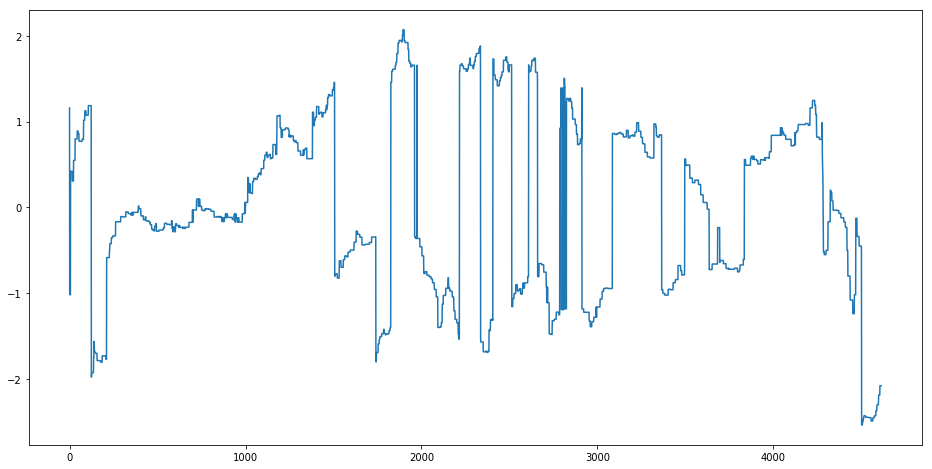

In [6]:
plt.plot(Y_Data)

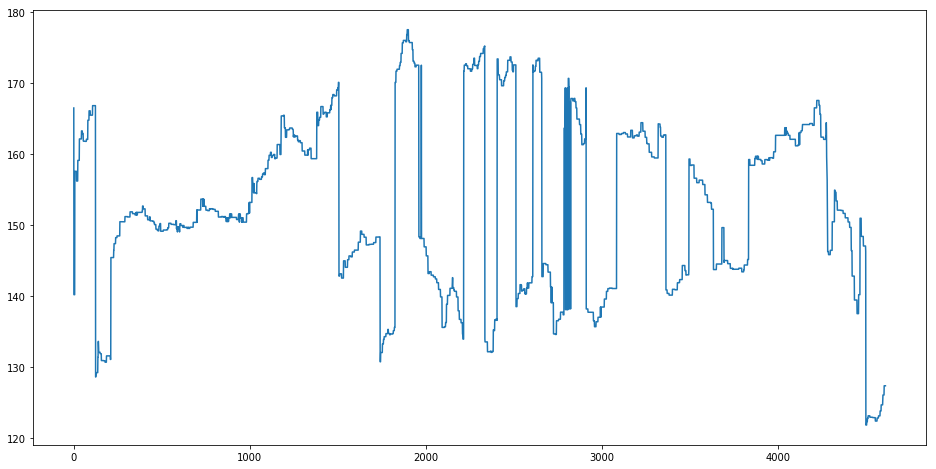

In [7]:
plt.plot(scaler.inverse_transform(Y_Data))

## split data set into training and test sets

We split our data into train and test sets. 75% for training and remainder for testing.

In [8]:
split = int(0.75 * len(xData))
X_train = np.array([x[0] for x in  xData[:split]])
xSeqlen = [x[1] for x in  xData[:split]]
X_test = np.array([x[0] for x in  xData[split:]])
xTestSeqlen = [x[1] for x in  xData[split:]]
Y_train = np.array(Y_Data[:split])
y_test = np.array(Y_Data[split:])
print(X_train.shape, X_test.shape, y_test.shape, Y_train.shape)

(3459, 20, 24) (1154, 20, 24) (1154, 1) (3459, 1)


## Model

The model is an RNN that uses an LSTM cell. An RNN works by processing seqential input step by step. For each word in 
our sentence, (now represented by vectors) the RNN process it by considering the words that it has processed before it. Here is a visualisation:

<img src="Screenshot%20from%202018-03-19%2011-43-37.png" />

The x's are our words and h's are our lstm outputs(sentence representation thus far given the words previously seen). We will use the final h: ht+2 as our sentence representation. <b>(The function called _last_relevant() does this work)</b>
We will then pass this representation to a normal feedfoward neural network with one layer <b>(W1)</b> and get a prediction <b>(prediction)</b>.
read more here: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

 For the cost function: we are trying to minimise the error between our predictions and the real values using the mean squared error function.

In [9]:
def _last_relevant(output, length):
    """
    get the last relevant tensor in an rnn
    output given real tensor length
    """
    batch_size = tf.shape(output)[0]
    max_length = int(output.get_shape()[1])
    output_size = int(output.get_shape()[2])
    index = tf.range(0, batch_size) * max_length + (tf.cast(length, tf.int32) - 1)
    flat = tf.reshape(output, [-1, output_size])
    relevant = tf.gather(flat, index)
    return relevant

target = tf.placeholder(tf.float32, [None, 1],name ="y_true")
data = tf.placeholder(tf.float32, [None, seq_length,emedding_size], name ="x_true") #Number of examples, seq_length, dimension of each input
sl = tf.placeholder(tf.float32, [None])
num_hidden = 56
learning_rate =3e-4
cellL = tf.contrib.rnn.LSTMCell(num_hidden)
#cellL = tf.contrib.rnn.DropoutWrapper(cell=cellL, input_keep_prob=.70,  output_keep_prob=.70)
outputs, last_states = tf.nn.dynamic_rnn(cell = cellL, dtype = tf.float32, sequence_length = sl, inputs = data)
last = _last_relevant(outputs, sl)
#last = tf.reduce_mean(data, axis=1)

# a linear layer
W1 = tf.get_variable("Linear_weight",shape=[num_hidden, 1],initializer=tf.truncated_normal_initializer(stddev=0.1))
prediction = tf.matmul(last, W1)

cost = tf.losses.mean_squared_error(target, prediction)

train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
saver = tf.train.Saver()


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training
for all training epochs we optimise the model {adjusting weights (w1 and lstm weights)} by amounts governed by the learning rate.(learning_rate). The cost should go down at each time step until the model can go no further

In [10]:
#training & testing modes

init_op = tf.global_variables_initializer()
sess = tf.Session()
summary_writer = tf.summary.FileWriter("/tmp/charLevel")
summary_writer.add_graph(sess.graph)
sess.run(init_op)
batch_size = int(len(X_train))
no_of_batches = int(len(X_train) / batch_size)
modelName = 'StockModel'
try:
    saver = tf.train.import_meta_graph(modelName+".meta")
    print("Loading variables from '%s'." % modelName)
    saver.restore(sess, tf.train.latest_checkpoint('./trainedModel2'))
    print("Success: Loaded variables from '%s'." % modelName)
except IOError:
    print("Not found: Creating new '%s'." % modelName)
testDict = {data: X_test, target: y_test, sl:xTestSeqlen}
trainDict = {data: X_train, target: Y_train, sl:xSeqlen}


mode = 0
if mode == 0:
    for i in range(training_epochs):
        ptr = 0
        for j in range(no_of_batches):
            inp, out, leno = X_train[ptr:ptr+batch_size], Y_train[ptr:ptr+batch_size], xSeqlen[ptr:ptr+batch_size]
            ptr+=batch_size
            sess.run(train_op, {data: inp, target: out, sl:leno})
        train_cost =float(sess.run(cost, trainDict))
        if i % display_step == 0:
            test_cost = sess.run(cost, testDict)
            print ("Epoch "+str(i)+" Train set cost: "+str(round(train_cost, 2)),"\t Test cost: ", round(test_cost, 2))
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=train_cost, tag="training_cost")
            episode_summary.value.add(simple_value=test_cost, tag="test_cost")
            summary_writer.add_summary(episode_summary, i)
            summary_writer.flush()
            if train_cost >33360.54:
                saver.save(sess, modelName)
                #sys.exit();

Not found: Creating new 'StockModel'.
Epoch 0 Train set cost: 1.01 	 Test cost:  1.0
Epoch 4 Train set cost: 1.01 	 Test cost:  0.97
Epoch 8 Train set cost: 1.01 	 Test cost:  0.99
Epoch 12 Train set cost: 1.01 	 Test cost:  1.0
Epoch 16 Train set cost: 1.01 	 Test cost:  0.98
Epoch 20 Train set cost: 1.01 	 Test cost:  0.98
Epoch 24 Train set cost: 1.01 	 Test cost:  0.98
Epoch 28 Train set cost: 1.0 	 Test cost:  0.99
